Now we create a function which masks the last two words of the disease name (both words if there are only two)
We will present this to the LLM and ask it to give use the masked words.
Two correct words will count as a 'known entity', two incorrect words will count as an 'unknown entity'.
Inbetween will count as a 'half-known entity' nd be dismissed form the analysis, as per Ferrando et al.

In [1]:
import goodfire
import os
import re
import pandas as pd
import json
from nltk import WordNetLemmatizer
from difflib import SequenceMatcher
import nest_asyncio
import asyncio
from tqdm import tqdm
from together import Together
import time
import logging
from datetime import datetime
from typing import List, Dict, Tuple
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm


In [2]:

api_key ='REDACTED'
client = goodfire.Client(api_key)
TOGETHER_API_KEY = 'REDACTED'
variant = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
os.environ["OPENAI_API_KEY"] = "REDACTED"


## Wikidata

In [25]:
pd.set_option('display.max_colwidth', 1000)
wikidata = pd.read_csv('../wikidata_dataset/formatted_entity_recognition_dataset.csv')
wikidata = wikidata.to_dict('records')

# add question marks so LLM knows these are queries to be answered
def append_question_mark(records):
    for record in records:
        if 'query' in record and record['query']:
            record['query'] = record['query'].rstrip('?') + '?'
    return records

wikidata = append_question_mark(wikidata)

wikidata[0:4]

[{'entity': 'Legg–Calvé–Perthes disease',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Legg–Calvé–Perthes disease was first identified by ?',
  'missing_words': "['Karel Maydl']"},
 {'entity': 'Wiskott-Aldrich syndrome',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Wiskott-Aldrich syndrome was first identified by ?',
  'missing_words': "['Alfred Wiskott']"},
 {'entity': 'Gordon-Holmes syndrome',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Gordon-Holmes syndrome was first identified by ?',
  'missing_words': "['Gordon Morgan Holmes']"},
 {'entity': 'erythromelalgia',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease erythromelalgia was first identified by ?',
  'missing_words': "['Silas Weir Mitchell']"}]

## Helper Functions

In [30]:

from tqdm import tqdm
from together import Together
import time

def query_to_llm_(records, provider="goodfire", missing_qty = 2):
    
    # Get data
    records_completed = []
    client_gf = goodfire.Client(api_key)
    client_tg = Together(api_key=TOGETHER_API_KEY)

    # loop over the data with tqdm progress bar
    for record in tqdm(records, desc="Processing records"):
    
        # Create query with instructions to LLM
        if missing_qty == 2:
            instruction = "Without preamble, give the two missing words as indicated by [Word A] and [Word B] in the following sentence. Return your answer as a python list:\n "
        elif missing_qty == 1:
            instruction = "Without preamble, give the missing word as indicated by [Word A] in the following sentence. Return your answer as a python list:\n "
        elif missing_qty == -1:
            instruction = "Without preamble, give the answer to the following question. Return your answer as a member of a python list:\n "

        else:
            print("No such quantity of missing words")
            return
            
        query = instruction + record['query']

        if provider == 'goodfire':
            
            # Simple rate limiting
            time.sleep(1.5)

            # Create a non-streaming completion using Goodfire
            response = client_gf.chat.completions.create(
                messages=[{"role": "user", "content": query}],
                model="meta-llama/Meta-Llama-3.1-8B-Instruct", # "meta-llama/Llama-3.3-70B-Instruct", "meta-llama/Meta-Llama-3.1-8B-Instruct"
            )
            llm_response = response.choices[0].message["content"]

        else:
            # call Together.ai

            try:
                response = client_tg.chat.completions.create(
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
                    messages=[{"role": "user", "content": query}],
                    temperature=0.0,
                )
                llm_response = response.choices[0].message.content

            except Exception as e:
                llm_response = ''
                print(e)

        # Save results
        record['llm_response'] = llm_response
        records_completed.append(record)

    return records_completed


In [33]:
import re

wikidata_completed_tg = query_to_llm_(wikidata, provider='together', missing_qty=-1)

Processing records: 100%|██████████| 732/732 [03:55<00:00,  3.11it/s]


In [35]:
# inspect sample
wikidata_completed_tg[0:4]

[{'entity': 'Legg–Calvé–Perthes disease',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Legg–Calvé–Perthes disease was first identified by ?',
  'missing_words': "['Karel Maydl']",
  'llm_response': "['Arthur Legg', 'Georges Calvé', 'Jacques Perthes']",
  'score': 0},
 {'entity': 'Wiskott-Aldrich syndrome',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Wiskott-Aldrich syndrome was first identified by ?',
  'missing_words': "['Alfred Wiskott']",
  'llm_response': "['Alfred Wiskott', 'Alice Steiner Aldrich']",
  'score': 0},
 {'entity': 'Gordon-Holmes syndrome',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease Gordon-Holmes syndrome was first identified by ?',
  'missing_words': "['Gordon Morgan Holmes']",
  'llm_response': "['Gordon Holmes']",
  'score': 0},
 {'entity': 'erythromelalgia',
  'description': nan,
  'id': nan,
  'red_herring': False,
  'query': 'The disease erythromel

## Does GPT4o LLM agree with the answers?



In [47]:
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import json
from langchain.prompts import ChatPromptTemplate

class QueryEvaluation(BaseModel):
    entity: str
    red_herring: bool
    query: str
    missing_words: str
    llm_response: str
    llm_response_opinion: int = 0

class ResponseEvaluationAgent:
    """
    Agent responsible for evaluating LLM responses against expected answers for disease-related questions.
    """
    async def run(self, llm, evaluation_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Evaluate LLM responses for disease-related questions.

        Args:
            llm: The language model to use for evaluation
            evaluation_records: List of records containing queries, responses, and expected answers

        Returns:
            List[Dict]: The evaluated records with LLM opinions added
        """
        try:
            tools = [{
                "name": "submit_evaluation",
                "description": "Submit evaluation of LLM response",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "is_acceptable": {
                            "type": "integer",
                            "description": "1 if the response is acceptable, 0 if not",
                            "enum": [0, 1]
                        }
                    },
                    "required": ["is_acceptable"]
                }
            }]

            evaluated_records = []

            for record in evaluation_records:
                messages = [
                    ("system", "You are a medical response evaluator."),
                    ("user", """
                    TASK: Evaluate if the LLM's response is an acceptable answer to the query.
                    
                    Context:
                    Disease: {entity}
                    
                    Query: {query}
                    Expected answer: {missing_words}
                    LLM's response: {llm_response}
                    
                    Instructions:
                    1. Consider if the LLM's response conveys the same meaning as the expected answer
                    2. The response should be evaluated based on medical accuracy and the disease description
                    2. If LLM gave a list of answers and an acceptable answer is among them, then mark it acceptable
                    3. Return 1 if acceptable, 0 if not acceptable
                    
                    Evaluate and submit using the 'submit_evaluation' tool.
                    """)
                ]
                
                prompt = ChatPromptTemplate.from_messages(messages)
                
                # Create and invoke the chain
                chain = (prompt | llm.bind_tools(tools, tool_choice="submit_evaluation"))
                response = await chain.ainvoke(record)
                
                # Extract evaluation
                func_args = response.additional_kwargs['tool_calls'][0]['function']['arguments']
                evaluation_result = json.loads(func_args)
                
                # Create evaluated record
                evaluated_record = record.copy()
                evaluated_record['llm_response_opinion'] = evaluation_result['is_acceptable']
                
                # Validate using Pydantic
                validated_record = QueryEvaluation(**evaluated_record)
                evaluated_records.append(validated_record.model_dump())

            return evaluated_records

        except json.JSONDecodeError as e:
            msg = f"Response Evaluation Agent Error: Invalid JSON: {str(e)}"
            print(msg)
            raise

        except KeyError as e:
            msg = f"Response Evaluation Agent Error: Missing key in JSON: {str(e)}"
            print(msg)
            raise

        except Exception as e:
            msg = f"Response Evaluation Agent Error: Unexpected error: {str(e)}"
            print(msg)
            raise

In [48]:
import asyncio
import nest_asyncio
from typing import List
import math
from tqdm.notebook import tqdm

# Enable asyncio in Jupyter
nest_asyncio.apply()

async def process_in_chunks(evaluator, llm, records: List[dict], chunk_size: int = 10):
    """Process records in chunks to avoid overwhelming the LLM service"""
    chunks = [records[i:i + chunk_size] for i in range(0, len(records), chunk_size)]
    all_results = []
    
    # Use tqdm with total number of chunks
    pbar = tqdm(total=len(chunks), desc="Processing chunks", unit="chunk")
    
    for chunk in chunks:
        chunk_results = await evaluator.run(llm, chunk)
        all_results.extend(chunk_results)
        pbar.update(1)
        
        # Optional: Add a small delay between chunks to avoid rate limits
        await asyncio.sleep(0.1)
    
    pbar.close()
    return all_results



In [49]:
from langchain_openai import ChatOpenAI

# Create the LLM instance
llm = ChatOpenAI(
    model="gpt-4o",  # or whatever model you're using
    temperature=0,
)

# Initialize your evaluator and llm objects first
evaluator = ResponseEvaluationAgent()

# Then run the processing
async def main():
    results = await process_in_chunks(evaluator, llm, wikidata_completed_tg, chunk_size=50)
    return results

# Execute in Jupyter
wikidata_completed_tg_scored = asyncio.run(main())

Processing chunks:   0%|          | 0/15 [00:00<?, ?chunk/s]

In [50]:
# save progress

pd.DataFrame(wikidata_completed_tg_scored).to_parquet('../classifier/data_classifier_movies/wikidata_completed_tg_scored.parquet')

In [52]:
wikidata_completed_tg_scored[0:4]

[{'entity': 'Legg–Calvé–Perthes disease',
  'red_herring': False,
  'query': 'The disease Legg–Calvé–Perthes disease was first identified by ?',
  'missing_words': "['Karel Maydl']",
  'llm_response': "['Arthur Legg', 'Georges Calvé', 'Jacques Perthes']",
  'llm_response_opinion': 0},
 {'entity': 'Wiskott-Aldrich syndrome',
  'red_herring': False,
  'query': 'The disease Wiskott-Aldrich syndrome was first identified by ?',
  'missing_words': "['Alfred Wiskott']",
  'llm_response': "['Alfred Wiskott', 'Alice Steiner Aldrich']",
  'llm_response_opinion': 1},
 {'entity': 'Gordon-Holmes syndrome',
  'red_herring': False,
  'query': 'The disease Gordon-Holmes syndrome was first identified by ?',
  'missing_words': "['Gordon Morgan Holmes']",
  'llm_response': "['Gordon Holmes']",
  'llm_response_opinion': 1},
 {'entity': 'erythromelalgia',
  'red_herring': False,
  'query': 'The disease erythromelalgia was first identified by ?',
  'missing_words': "['Silas Weir Mitchell']",
  'llm_response

In [72]:
# load progress
import pandas as pd
wikidata_completed_tg_scored = pd.read_parquet('../classifier/data_classifier_movies/wikidata_completed_tg_scored.parquet')
wikidata_completed_tg_scored = wikidata_completed_tg_scored.to_dict('records')


We now have two questions per record, i.e. two records per id.
We need to group these by id in order to score each entity as having 0, 1, or 2 attributes correctly named by the LLM.
So, a new scoring function...

In [73]:
# We need a fuction to score split data

def calculate_combined_scores(split_data, score_type='llm_response_opinion'):
    """
    Calculate scores for the original queries based on their split versions.
    
    Args:
        split_data (list): List of dictionaries containing split queries with individual scores
        
    Returns:
        tuple: (total_score_2, total_score_1, total_score_0) counts for queries where 
               2, 1, or 0 words were correctly guessed
    """
    # Group the split queries by their ID
    query_scores = {}
    for item in split_data:
        query_id = item['entity']
        if query_id not in query_scores:
            query_scores[query_id] = []
        query_scores[query_id].append(item[score_type])
    
    # Count queries based on combined scores, start at zero
    score_2 = 0  # Both words correct
    score_1 = 0  # One word correct
    score_0 = 0  # No words correct

    for query_id, scores in query_scores.items():
        # Each query should have exactly 2 scores (Word A and Word B)
        assert len(scores) == 2, f"Query {query_id} has {len(scores)} scores instead of 2"
        
        # Sum the individual scores for the query
        total_correct = sum(scores)

        if total_correct == 2:  # Both words correctgit add src/classifier/FerrandoEtAl_Data_final.ipynb
            score_2 += 1
        elif total_correct == 1:  # One word correct
            score_1 += 1
            
        else:  # No words correct
            score_0 += 1
    
    return score_0, score_1, score_2



In [74]:
# Scores BASED ON GPT4o opinion
scores = calculate_combined_scores(wikidata_completed_tg_scored, score_type='llm_response_opinion')
print("Based on EXACT scoring, we have:")
print(f"Known Entities    : {scores[2]}")
print(f"Uncertain Entities: {scores[1]}")
print(f"Unknown Entities  : {scores[0]}")

Based on EXACT scoring, we have:
Known Entities    : 46
Uncertain Entities: 178
Unknown Entities  : 142


In [75]:
# function to separate data into known and unknown entities

def filter_score_sets(data, score_type='llm_response_opinion'):
    """
    Filter data into two sets based on combined scores per ID.
    
    Args:
        data (list): List of dictionaries containing query data with scores
        
    Returns:
        tuple: (perfect_scores, zero_scores) where each is a list of dictionaries
               containing unique id, entity, and description for entries with
               total scores of 2 and 0 respectively
    """
    # First, group by ID and calculate total scores
    grouped_scores = {}
    for item in data:
        if item['entity'] not in grouped_scores:
            grouped_scores[item['entity']] = {
                'total_score': 0,
                'entity': item['entity'],
            }
        grouped_scores[item['entity']]['total_score'] += item[score_type]
    
    # Filter into two sets
    perfect_scores = [
        {
            'entity': info['entity'],
        }
        for info in grouped_scores.values()
        if info['total_score'] == 2
    ]
    
    zero_scores = [
        {
            'entity': info['entity'],
        }
        for info in grouped_scores.values()
        if info['total_score'] == 0
    ]
    
    return perfect_scores, zero_scores

In [76]:
# The known and unknown entities are as follows:
import random

records_known, records_unknown = filter_score_sets(wikidata_completed_tg_scored, score_type='llm_response_opinion')

entities_known_1Q  = [record['entity'] for record in records_known]
print("No. of known entities = ", len(entities_known_1Q))
print("Examples: ", random.sample(entities_known_1Q, 4))
print('\n')

entities_unknown_1Q = [record['entity'] for record in records_unknown]
print("No. of unknown entities = ", len(entities_unknown_1Q))
print("Examples: ", random.sample(entities_unknown_1Q, 4))

No. of known entities =  46
Examples:  ['catecholaminergic polymorphic ventricular tachycardia', "Huntington's disease", 'maple syrup urine disease', 'Wiskott-Aldrich syndrome']


No. of unknown entities =  142
Examples:  ['buprenorphine/naloxone', 'Neu-Laxova syndrome 1', 'Mungan syndrome', 'poikiloderma with neutropenia']


When using the previous dataset we had to remove duplicates, i.e. entities which appeared in both the known and unknown lists. 
That is not a concern with this Human DO dataset, so we cna skip that step and move directly to getting feature activations from Goodfire.

Beware, slow process!

In [77]:
# Save progress

import csv

def save_list_to_file(data_list, filename):
    """
    Saves a list to a file, properly handling commas and special characters.
    
    Args:
        data_list (list): The list to save
        filename (str): Name of the output file
    """
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file, quoting=csv.QUOTE_ALL)
            # Write each item as a row
            for item in data_list:
                writer.writerow([item])
        print(f"Successfully saved list to {filename}")
    except Exception as e:
        print(f"Error saving list: {e}")


# Apply save function
save_list_to_file(entities_known_1Q, '../classifier/data_classifier_movies/entities_known_1Q.csv' )
save_list_to_file(entities_unknown_1Q, '../classifier/data_classifier_movies/entities_unknown_1Q.csv' )

Successfully saved list to ../classifier/data_classifier_movies/entities_known_1Q.csv
Successfully saved list to ../classifier/data_classifier_movies/entities_unknown_1Q.csv


In [78]:
entities_known_1Q[0:4]

['Wiskott-Aldrich syndrome',
 "Huntington's disease",
 'Unverricht-Lundborg syndrome',
 'DiGeorge syndrome']

In [80]:
def filter_dicts_by_entities(records, known_entities, unknown_entities):
    """
    Filters and transforms a list of dictionaries based on known and unknown entities.

    Args:
        records (list of dict): The original list of dictionaries to filter and transform.
        known_entities (list of str): A list of known entity names.
        unknown_entities (list of str): A list of unknown entity names.

    Returns:
        list of dict: The filtered and transformed list of dictionaries.
    """
    filtered_records = []

    for record in records:
        entity = record.get('entity')

        # Determine if the entity is in known or unknown lists
        if entity in known_entities:
            record['known_unknown'] = 'known'
        elif entity in unknown_entities:
            record['known_unknown'] = 'unknown'
        else:
            continue  # Skip records not matching either list

        # Transform the 'missing_words' key to 'answer_expected'
        if 'missing_words' in record:
            record['answer_expected'] = record['missing_words'].strip('[]').strip().strip("'")

        # Transform the 'llm_response' key to a simple string
        if 'llm_response' in record:
            llm_response = record['llm_response']
            if isinstance(llm_response, str) and llm_response.startswith("[") and llm_response.endswith("]"):
                # Remove brackets and quotes, then strip
                record['llm_response'] = llm_response.strip("[]'\"")

        # Add the transformed record to the filtered list
        filtered_records.append(record)

    return filtered_records

In [81]:
queries_for_feature_extraction = filter_dicts_by_entities(wikidata_completed_tg_scored, entities_known_1Q, entities_unknown_1Q)

# save to file
pd.DataFrame(queries_for_feature_extraction).to_parquet('../classifier/data_classifier_movies/queries_for_feature_extraction.parquet')

# view examples
queries_for_feature_extraction[0:4]

[{'entity': 'Legg–Calvé–Perthes disease',
  'red_herring': False,
  'query': 'The disease Legg–Calvé–Perthes disease was first identified by ?',
  'missing_words': "['Karel Maydl']",
  'llm_response': "Arthur Legg', 'Georges Calvé', 'Jacques Perthes",
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'Karel Maydl'},
 {'entity': 'Wiskott-Aldrich syndrome',
  'red_herring': False,
  'query': 'The disease Wiskott-Aldrich syndrome was first identified by ?',
  'missing_words': "['Alfred Wiskott']",
  'llm_response': "Alfred Wiskott', 'Alice Steiner Aldrich",
  'llm_response_opinion': 1,
  'known_unknown': 'known',
  'answer_expected': 'Alfred Wiskott'},
 {'entity': 'chronic congestive splenomegaly',
  'red_herring': False,
  'query': 'The disease chronic congestive splenomegaly was first identified by ?',
  'missing_words': "['Guido Banti']",
  'llm_response': 'William Osler',
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'Gui

In [82]:
# Load progress

import pandas as pd

# load data
queries_for_feature_extraction = pd.read_parquet('../classifier/data_classifier_movies/queries_for_feature_extraction.parquet' )

# convert from pandas to list of dicts
queries_for_feature_extraction = queries_for_feature_extraction.to_dict('records')

# insepct sample
queries_for_feature_extraction[0:4]

[{'entity': 'Legg–Calvé–Perthes disease',
  'red_herring': False,
  'query': 'The disease Legg–Calvé–Perthes disease was first identified by ?',
  'missing_words': "['Karel Maydl']",
  'llm_response': "Arthur Legg', 'Georges Calvé', 'Jacques Perthes",
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'Karel Maydl'},
 {'entity': 'Wiskott-Aldrich syndrome',
  'red_herring': False,
  'query': 'The disease Wiskott-Aldrich syndrome was first identified by ?',
  'missing_words': "['Alfred Wiskott']",
  'llm_response': "Alfred Wiskott', 'Alice Steiner Aldrich",
  'llm_response_opinion': 1,
  'known_unknown': 'known',
  'answer_expected': 'Alfred Wiskott'},
 {'entity': 'chronic congestive splenomegaly',
  'red_herring': False,
  'query': 'The disease chronic congestive splenomegaly was first identified by ?',
  'missing_words': "['Guido Banti']",
  'llm_response': 'William Osler',
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'Gui

### USE MAIN.PY

Now use main.py to process the data, queries_for_feature_extraction.

1. Ensure you are in correct folder in terminal
2. Export the apikey:
    export GOODFIRE_API_KEY='sk-goodfire-ibWO6JlzNSqpcoDwh-4J8sh3kKXfhjvl08QJBRLAmorknu3dRL7CGg'
3. python main.py

Both data and main.py are in the 'data_classifier_movies' folder.


## Load Progress


In [83]:
import pickle

# Load feature activations for known data
with open('../classifier/data_classifier_movies/feature_activations_known_1Q.pkl', 'rb') as f:
    feature_activations_known_1Q = pickle.load(f)

# Load feature library for known data
with open('../classifier/data_classifier_movies/feature_library_known_1Q.pkl', 'rb') as f:
    feature_library_known_1Q = pickle.load(f)

# Load feature activations for unknown data
with open('../classifier/data_classifier_movies/feature_activations_unknown_1Q.pkl', 'rb') as f:
    feature_activations_unknown_1Q = pickle.load(f)

# Load feature library for unknown data
with open('../classifier/data_classifier_movies/feature_library_unknown_1Q.pkl', 'rb') as f:
    feature_library_unknown_1Q = pickle.load(f)

In [84]:
# inspect example
list(feature_library_known_1Q)[0:2]

[(UUID('55588796-ad18-440b-a49e-c09afe1d6047'),
  "Copular uses of 'to be' in definitional or classificatory statements"),
 (UUID('1a5e933f-e8a5-4417-8ffc-4844d94367e0'),
  'Conversation reset marker for context boundaries')]

In [85]:
from collections import defaultdict
from typing import List, Dict, Set, Tuple
from uuid import UUID

def analyze_feature_separation(
    feature_activations_known: List[Dict],
    feature_activations_unknown: List[Dict],
    feature_library_known: Set[Tuple[UUID, str]],
    feature_library_unknown: Set[Tuple[UUID, str]]
) -> List[Tuple[str, float, float, float]]:
    """
    Analyzes feature activation patterns between known and unknown entities.
    
    Returns list of tuples: (feature_label, known_fraction, unknown_fraction, separation_score)
    sorted by absolute separation score (highest to lowest)
    """
    # Convert feature libraries to dict for easier lookup
    known_labels = dict(feature_library_known)
    unknown_labels = dict(feature_library_unknown)
    
    # Count feature occurrences
    known_counts = defaultdict(int)
    unknown_counts = defaultdict(int)
    
    # Count total records
    n_known = len(feature_activations_known)
    n_unknown = len(feature_activations_unknown)
    
    # Count feature occurrences in known entities
    for record in feature_activations_known:
        for feature in record['entity_features']:
            known_counts[feature['uuid']] += 1
            
    # Count feature occurrences in unknown entities
    for record in feature_activations_unknown:
        for feature in record['entity_features']:
            unknown_counts[feature['uuid']] += 1
    
    # Get all unique features
    all_features = set(known_counts.keys()) | set(unknown_counts.keys())
    
    # Calculate fractions and separation scores
    results = []
    for feature_id in all_features:
        # Get feature label
        label = known_labels.get(feature_id) or unknown_labels.get(feature_id) or str(feature_id)
        
        # Calculate fractions
        known_fraction = known_counts[feature_id] / n_known if n_known > 0 else 0
        unknown_fraction = unknown_counts[feature_id] / n_unknown if n_unknown > 0 else 0
        
        # Calculate separation score (difference in occurrence rates)
        separation_score = known_fraction - unknown_fraction
        
        results.append((label, feature_id, known_fraction, unknown_fraction, separation_score))
    
    # Sort by absolute separation score (highest to lowest)
    results.sort(key=lambda x: abs(x[3]), reverse=True)
    
    return results


In [86]:
# use the function
results = analyze_feature_separation(
    feature_activations_known_1Q,
    feature_activations_unknown_1Q,
    feature_library_known_1Q,
    feature_library_unknown_1Q
)

# Convert to pandas for presentation
feature_separations = pd.DataFrame(results)
feature_separations.columns = ['label', 'feature_id', 'known_frac', 'unknown_frac', 'sep_score' ]



In [87]:

# Investigate features most exclusive to unknown entities

pd.set_option('display.max_colwidth', None)
feature_separations.sort_values(['known_frac','unknown_frac'], ascending=[True, False]).head(15)

,label,feature_id,known_frac,unknown_frac,sep_score
130,Formal terminology for skeletal joints and structural connections in anatomy,1479d6c9-f0bf-4faf-91d7-7dd82d64cd62,0.0,0.137324,-0.137324
170,Interactive fiction scripting commands and control flow syntax,cc6e3a46-2761-4aa2-9472-bbec0ddc7063,0.0,0.080986,-0.080986
174,The assistant needs clarification or lacks sufficient information,2501aec1-4a37-4392-8f3b-bedbf768307d,0.0,0.077465,-0.077465
182,The assistant is providing a structured list or enumeration,f8d8bb3e-61e6-49e6-b12b-0023b3c3618e,0.0,0.070423,-0.070423
184,Hyphenated compound terms in technical documentation,1da4d9bb-ea0b-4898-a658-0819665dd8e0,0.0,0.066901,-0.066901
188,Multi-word proper nouns and brand names,2b40e57a-f8d9-46b2-a871-da77abc9dd8a,0.0,0.063380,-0.063380
207,Subword tokens in multilingual text transitions and transliterations,33e5b1e8-b0b9-4f82-a5cc-83f3e05293ea,0.0,0.056338,-0.056338
209,Syntactical separators in programming (namespace operators and URL components),da9bc3be-5b4c-4ec1-b6a7-4616cda25e11,0.0,0.056338,-0.056338
215,Syntactical sugar in programming languages,59082009-f24d-4b35-bcc3-a3e53df9996d,0.0,0.052817,-0.052817
227,Medical terminology related to blood disorders and blood test results,37216120-2182-47bd-b04b-7c00f168ebcb,0.0,0.049296,-0.049296


In [88]:
## First view highest separation scores.., note this is not same as exclusivity
pd.set_option('display.max_colwidth', None)
feature_separations.sort_values('sep_score', ascending=True).head(15)

,label,feature_id,known_frac,unknown_frac,sep_score
54,"Medical condition name suffixes (-itis, -oma, -osis)",b391dcf0-2080-4c6b-863c-d5f6067b776b,0.510870,0.753521,-0.242652
61,"Grammatical connectors in explanatory text (commas, transitions, list markers)",880e3fe2-c827-4ffb-aaf0-7ab649fca398,0.304348,0.500000,-0.195652
76,Subword tokenization patterns in compound terms,c6e3d135-6e30-4d02-9e9e-8a0a91998920,0.228261,0.419014,-0.190753
112,The assistant is providing a formatted list or enumeration,fba31f1f-0b24-483a-98f2-cbb30c904a79,0.010870,0.200704,-0.189835
107,Japanese isekai and fantasy light novel/anime titles and terminology,8aecd299-4533-4949-aae6-4ee44d3701b0,0.021739,0.211268,-0.189528
91,"Expressions of personal capability, interest, or desire",5fb14eb9-17ea-423a-a896-bdf28f603296,0.108696,0.292254,-0.183558
102,Basic structural connectors for lists and simple relationships,4d60f0be-8bc8-49cc-82f9-1656bfc693ac,0.054348,0.228873,-0.174525
104,Connecting syllables in long scientific/technical terms,da9fb379-fe7d-4fa8-953b-91dc06d7a6a7,0.054348,0.218310,-0.163962
94,First letters/prefixes of technical or scientific terminology,48a5f323-6f7e-4f6d-bc13-1c254368da34,0.119565,0.281690,-0.162125
92,Standardized technical identifiers and version nomenclature in specifications,b842ff21-7e7c-4f08-b695-5e9b66b6d8a7,0.130435,0.288732,-0.158298


# These features are interesting, being RLHF about known vs unknown...



In [89]:
# Let's investigate the unknown feature, feature_0
def find_entity_by_uuid(records_list, target_uuid):
    """
    Find unique entity names where the given UUID exists in entity_features
    
    Args:
        records_list (list): List of dictionaries containing entity records
        target_uuid (str or UUID): UUID to search for
        
    Returns:
        list: List of unique entity names that contain the target UUID
    """
    # Convert target_uuid to string for comparison if it's not already
    target_uuid_str = str(target_uuid)
    
    # Use a set for automatic deduplication
    matching_entities = set()
    
    for record in records_list:
        # Check each feature in entity_features
        for feature in record['entity_features']:
            if str(feature['uuid']) == target_uuid_str:
                matching_entities.add(record['entity'])
                break  # Found a match, no need to check other features
                
    # Convert set back to list for return
    return list(matching_entities)


In [90]:
def get_feature_object(uuid_feature, feature_activations_list, client, variant, print_uuid=False):
    entities = find_entity_by_uuid(feature_activations_list, uuid_feature)
    if not entities:
        raise ValueError(f"No entities found for UUID {uuid_feature}")
    
    feature_entity_name = entities[0]  # Add index bounds check here
    
    inspector = client.features.inspect(
        [{"role": "user", "content": feature_entity_name}],
        model=variant
    )

    feature = None
    for activation in inspector.top(k=100):
        if str(activation.feature.uuid) == uuid_feature:
            feature = activation.feature
            break
            
    if feature is None:
        raise ValueError(f"Feature not found for UUID {uuid_feature}")

    # Get neighbors of a feature
    neighbors =  client.features.neighbors(
        feature,
        model=variant,
        top_k=10
    )

    print ("Neighbouring Features for: ", feature.label)
    print(feature.uuid)
    print ("--------------------------")

    for neighbor in neighbors:
        print(neighbor.label)
        if print_uuid:
            print(neighbor.uuid)

    return feature

# Let's investigate the top differentiating features which may generalise:

Bearing in mind we are interested in GENERALISED features which may indicate whether the entity is known or known:

- "The assistant needs clarification or lacks sufficient information"
    - 2501aec1-4a37-4392-8f3b-bedbf768307d


In [91]:
# 'Nonsensical or potentially harmful input requiring clarification or rejection',

get_feature_object(
    '2501aec1-4a37-4392-8f3b-bedbf768307d', 
    feature_activations_unknown_1Q,
    client,
    variant)
# 


Neighbouring Features for:  The assistant needs clarification or lacks sufficient information
2501aec1-4a37-4392-8f3b-bedbf768307d
--------------------------
The assistant needs clarification
The assistant acknowledging limitations or inability
The assistant needs to express uncertainty or correct previous statements
The assistant is formatting its response with structured spacing and line breaks
The assistant needs to explain it cannot actually search the internet
The assistant is providing a formatted list or enumeration
The assistant needs to express knowledge limitations and request clarification
Sentence boundaries in assistant's factual explanations
The assistant expressing uncertainty or hedging claims
Recognition and handling of NAME_1 placeholder tokens for anonymized proper nouns


Feature("The assistant needs clarification or lacks sufficient information")

### Scatter Graph

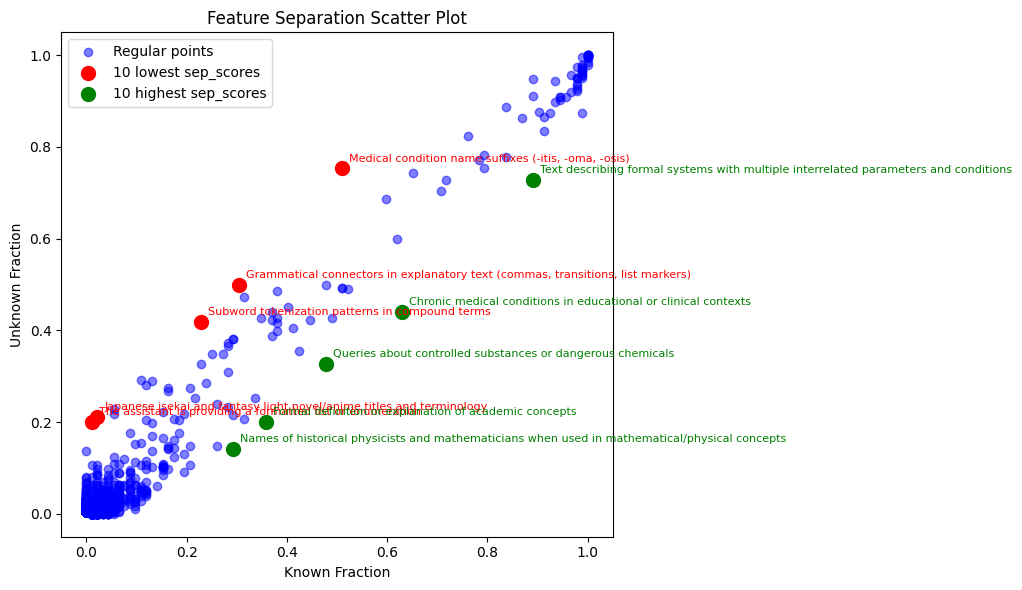

In [92]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plot all points in blue
plt.scatter(feature_separations['known_frac'], 
           feature_separations['unknown_frac'], 
           alpha=0.5, 
           color='blue', 
           label='Regular points')

# Get indices of top 10 lowest and highest sep_scores
lowest_scores_idx = feature_separations['sep_score'].nsmallest(5).index
highest_scores_idx = feature_separations['sep_score'].nlargest(5).index

# Highlight lowest scores in red
plt.scatter(feature_separations.loc[lowest_scores_idx, 'known_frac'],
           feature_separations.loc[lowest_scores_idx, 'unknown_frac'],
           color='red',
           s=100,
           label='10 lowest sep_scores')

# Highlight highest scores in green
plt.scatter(feature_separations.loc[highest_scores_idx, 'known_frac'],
           feature_separations.loc[highest_scores_idx, 'unknown_frac'],
           color='green',
           s=100,
           label='10 highest sep_scores')

plt.xlabel('Known Fraction')
plt.ylabel('Unknown Fraction')
plt.title('Feature Separation Scatter Plot')
plt.legend()

# Add label annotations for both sets of highlighted points
for idx in lowest_scores_idx:

    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='red', fontsize=8)

for idx in highest_scores_idx:
    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='green', fontsize=8)

plt.tight_layout()
plt.show()

In [93]:

"src/classifier/data_classifier_movies/entities_unknown_1Q.csv"
"src/classifier/data_classifier_movies/entities_known_1Q.csv"


['Legg–Calvé–Perthes disease',
 'chronic congestive splenomegaly',
 'microphthalmia with limb anomalies',
 'phlebotomus fever',
 'zoochosis',
 'Kabuki syndrome',
 'Paris syndrome',
 'hereditary spastic paraplegia 23',
 "Wartenberg's Syndrome",
 '3-methylglutaconic aciduria type 3',
 'amentia',
 'Tumoral calcinosis',
 'Lasthenie de Ferjol syndrome',
 'malaria',
 'granular corneal dystrophy type I',
 'opsoclonus myoclonus syndrome',
 'Robinow syndrome',
 'hh blood group',
 'spinocerebellar ataxia type 28',
 'urofacial syndrome',
 'Native American myopathy',
 'Smith–Fineman–Myers syndrome',
 'congenital disorder of glycosylation Ir',
 'reticular dysgenesis',
 'Wiedemann-Steiner syndrome',
 'autism',
 'common variable immunodeficiency',
 'du Pan syndrome',
 'Baraitser-Winter syndrome',
 'eosinophilic esophagitis',
 'platelet-type bleeding disorder 15',
 'autoimmune lymphoproliferative syndrome',
 'Hajdu-Cheney syndrome',
 'familial hemiplegic migraine',
 'arterial calcification of infancy'